In [640]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from joblib import delayed,Parallel
from itertools import combinations
from functools import partial
import numpy as np
import gc
import pickle
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
timestamp = time()

In [641]:
###Functions
def timer(timestamp):
    #Timer Function
    print("time =", time()-timestamp)
    return

def fin_string(ns,s): #ns = length of string s = operator
    #Max string length
    if ns>L:
        ns=L
    else:
        pass
    
    
    def linears(start,m):
        #Find all indices in string
        ind=[i%L for i in range(start,start+ns)]
     #All combinations
        perm=list(combinations(ind,m))
      #Add each coupling to operator
        for j in range(len(perm)):
#            S_temp=[((-1)**m)*(2**m)/(L*(2**ns))] ########### Down #
            S_temp=[1/(L*(2**ns))] ###################### Up
            for i in range(len(perm[j])):
                S_temp.append(perm[j][i])
        ##Saving Couplin gs lists
            if j==0: 
                S_temp_2=[S_temp]
            else: 
                S_temp_2.append(S_temp)
        return S_temp_2
    #List to store orders of interaction
    o_type=np.empty(ns,dtype=object)
    
    for i in range(ns):
        #ex: "z"*2= "zz"
        o_type[i]=s*(i+1)

    #Iterate over each Site
    for k in range(L):
        #Iterate over different string lengths
      for i in range(ns):
          #First item defines list
          if k==0 and i==0:
              #example: i = 0 operator_list = [['x', linears(k,1)]]
              operator_list=[[o_type[i],linears(k,i+1)]]
          else:
              operator_list.append([o_type[i],linears(k,i+1)])
    S_temp_1 = [[(1/((ns*2**ns))), i] for i in range(ns)]
    #S_temp_1 = [[(1/((ns*2**(ns)))), 1] ]
    operator_list.append(["I",S_temp_1])
    operator_dict=dict(S=operator_list)
    O = quantum_operator(operator_dict,basis=basis,check_symm=False,check_herm=False)
    return O, operator_list

In [642]:
###### Model parameters

#Length of chain
L = 8
#X fields
J1 = 1 #NN term 
J2 = 0 #NNN Term
#Initial z field strength
h0 = .5 
#Final z fields
h_i,dh = np.linspace(0,3,100,retstep=True)
#Time
times,dt=np.linspace(0.0,50,1000,retstep=True)
#Basis being projected
op = "x"

In [643]:
###Using Quantum_Operator to build hamitlonian 
timestamp = time()
basis = spin_basis_1d(L, pauli = -1, pblock= 1)


#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Define Parameters
params_dict = dict( H0=1, Quench=0)
#Build H0
H0 = H.tohamiltonian(params_dict);
#Find eigenvalues
E,V = np.linalg.eigh(H0.todense())
#Convert matrix to array
V = np.array(V)
#Ground state of unquenched hamiltonian
V0= V[:,0]
D = len(V0)

#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]


In [644]:
def quench_function(t,tau,h0,hf):
    return h0+ (hf-h0)*(t/tau)
tau = 2
t = np.arange(0,tau,0.01)

h0 = 0
hf = 2

h = quench_function(t,tau,h0,hf)


FF =[H.tohamiltonian(dict(H0=1,Quench=hi)).eigh()[1][:,0] for hi in h]

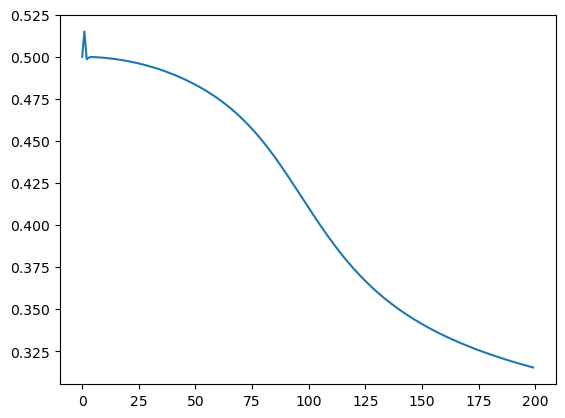

In [645]:
plt.plot([Projectors[1].expt_value(FF[i]) for i in range(len(FF))])

In [646]:
import quspin
hf = 3/2
params_dict2 = dict( H0=1, Quench=hf)
Hf = H.tohamiltonian(params_dict2);
Ef,Vf = np.linalg.eigh(Hf.todense())


times = np.linspace(0,2,100)
El,Vl,Q = quspin.tools.lanczos.lanczos_full(Hf,V0,15)

In [647]:
v_t_list = []
for t in times:
    expH_v0 = quspin.tools.lanczos.expm_lanczos(El,Vl,Q,-1j*t)
    v_t_list.append(expH_v0)


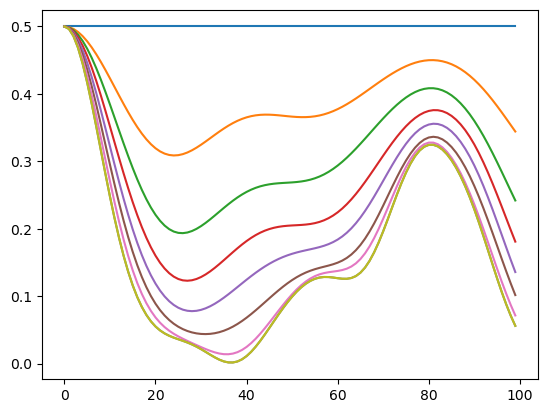

In [648]:
for i in Projectors:
    plt.plot([i.expt_value(v_t_list[j]) for j in range(len(v_t_list))])
plt.plot([np.abs(V0@v_t_list[j])**2/2 for j in range(len(v_t_list))],label="Ground State")
#plt.yscale('log')

In [518]:
from quspin.tools.lanczos import lanczos_full, expm_lanczos
h0 = 0 
H0 = H.tohamiltonian(dict(H0=1,Quench=h0))
E0,V = np.linalg.eigh(H0.todense())
V = np.array(V)
V0 = V[:,0]
V1 = V[:,1]

hF = 0.1
v_t = V0.copy()
v_t_list = [v_t.copy()]

times = np.linspace(0, 50, 200)
dt = times[1] - times[0]

def h(t,tau,h0,hf):
    return h0 + (hf - h0) * (t / tau)

for t in times[1:]:
    hf = h(t,times[-1],0,hF)  # define your time-dependent field, e.g. hf = h0 + (hf-h0)*t/tau
    params_dict = dict(H0=1, Quench=hf)
    Ht = H.tohamiltonian(params_dict)

    # Lanczos evolution for dt
    El, Vl, Q = lanczos_full(Ht, v_t, 15)
    v_t = expm_lanczos(El, Vl, Q, -1j * dt)
    v_t_list.append(v_t.copy())
    print(El[0]-E[1])

Hf = H.tohamiltonian(dict(H0=1,Quench=hF))
Ef, Vf = np.linalg.eigh(Hf.todense())
Vf = np.array(Vf)


-5.050377600568368e-07
-2.0201511601314337e-06
-4.5453404533546404e-06
-8.080606098026522e-06
-1.2625948797584385e-05
-1.818136939579773e-05
-2.4746868990455084e-05
-3.232244876638646e-05
-4.090811019796803e-05
-5.050385488392095e-05
-6.110968465211641e-05
-7.272560153825935e-05
-8.535160768641248e-05
-9.898770555505365e-05
-0.00011363389766305687
-0.00012929018679219695
-0.00014595657597293865
-0.00016363306829791924
-0.00018231966709780778
-0.0002020163760141358
-0.00022272319866178947
-0.0002444401390073736
-0.0002671672011986814
-0.0002909043895380492
-0.00031565170844150003
-0.0003414091626874338
-0.0003681767570986594
-0.0003959544967626627
-0.00042474238694811817
-0.0004545404331031122
-0.0004853486408800123
-0.0005171670160981634
-0.0005499955647971788
-0.0005838342931836493
-0.0006186832077110793
-0.0006545423149288965
-0.0006914116216458766
-0.0007292911348626419
-0.0007681808617485686
-0.0008080808096577741
-0.0008489909861681966
-0.0008909113990211992
-0.0009338420561837424

[[0.34616687+0.j]]
[[0.34616687]]


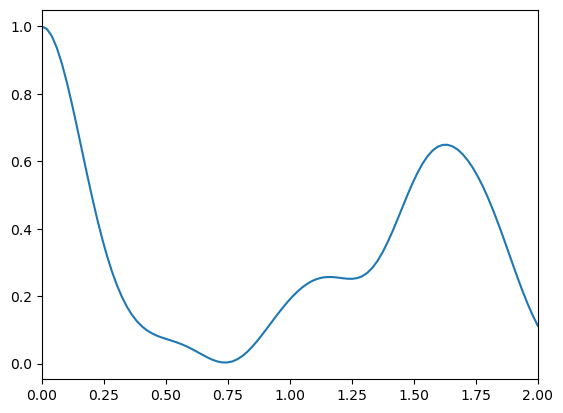

In [650]:
plt.plot( times,[np.abs(V[:,0]@v_t_list[i])**2 for i in range(len(v_t_list))],label="Ground State")
#plt.plot( times,[np.abs(Vf[:,1]@v_t_list[i])**2 for i in range(len(v_t_list))],label="First Excited State")

plt.xlim(times[0],times[-1])
print((V[:,0]@Vf[:,1])**2)
print(np.abs(v_t_list[-1]@Vf[:,1])**2)
#plt.yscale('log')

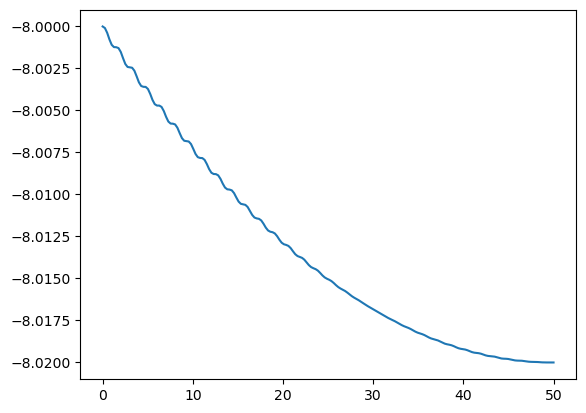

In [514]:
plt.plot( times,[Hf.expt_value(v_t_list[i]) for i in range(len(v_t_list))],label="First Excited State")


In [651]:
import numpy as np
from quspin.tools.lanczos import lanczos_full, expm_lanczos

def adiabatic_lanczos_evolution(H, h0, hf, tau, steps=200, krylov_dim=15):
    """
    Perform adiabatic time evolution using Lanczos approximation.

    Parameters:
        H           : quspin operator_dict Hamiltonian object
        h0          : initial field value
        hf          : final field value
        tau         : total evolution time
        steps       : number of time steps
        krylov_dim  : dimension of Krylov subspace

    Returns:
        v_t_list    : list of evolved states at each time
        V0          : initial ground state
        Vf[:,0]     : final ground state
        times       : array of time values
        h_vals      : array of h(t) values
    """
    # initial Hamiltonian and ground state
    H0 = H.tohamiltonian(dict(H0=1, Quench=h0))
    E0, V0_full = np.linalg.eigh(H0.todense())
    V0 = np.array(V0_full)[:, 0]

    # time grid
    times = np.linspace(0, tau, steps)
    dt = times[1] - times[0]
    h_vals = h0 + (hf - h0) * (times / tau)

    # time evolution
    v_t = V0.copy()
    v_t_list = [v_t.copy()]
    for t, h_val in zip(times[1:], h_vals[1:]):
        Ht = H.tohamiltonian(dict(H0=1, Quench=h_val))
        El, Vl, Q = lanczos_full(Ht, v_t, krylov_dim)
        v_t = expm_lanczos(El, Vl, Q, -1j * dt)
        v_t_list.append(v_t.copy())

    # final ground state
    Hf = H.tohamiltonian(dict(H0=1, Quench=hf))
    Ef, Vf = np.linalg.eigh(Hf.todense())
    Vf = np.array(Vf)

    return v_t_list, V0, Vf, times, h_vals


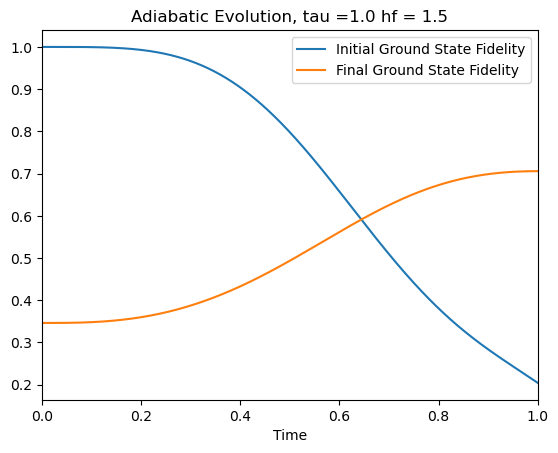

In [669]:
vt,V0,Vf,times,hvals = adiabatic_lanczos_evolution(H, 0, 1.5, 1, steps=500, krylov_dim=15)
plt.plot(times,[np.abs(V0@vt[i])**2 for i in range(len(vt))],label="Initial Ground State Fidelity")
plt.plot(times,[np.abs(Vf[:,1]@vt[i])**2 for i in range(len(vt))],label="Final Ground State Fidelity")
plt.xlim(times[0],times[-1])
plt.title("Adiabatic Evolution, tau =" + str(times[-1]) + " hf = " + str(hvals[-1]))
plt.xlabel("Time")
plt.legend()


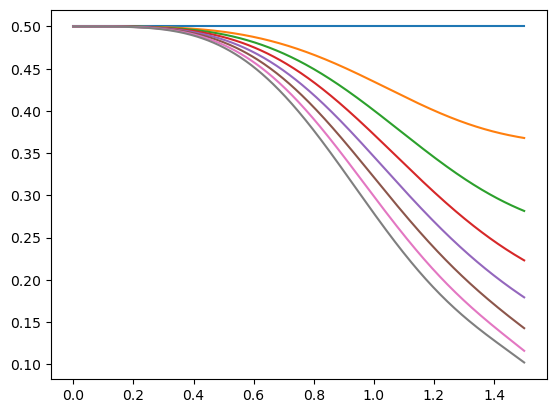

In [670]:
for P in Projectors:
    plt.plot(hvals,[P.expt_value(vt[i]) for i in range(len(vt))],label="First Excited State")

In [683]:
import numpy as np
from quspin.tools.lanczos import lanczos_full, expm_lanczos

def final_states_vs_hf(H, h0, hf_list, tau, steps=200, krylov_dim=15):
    """
    Perform adiabatic time evolution for multiple hf values.
    
    Parameters:
        H           : quspin operator_dict Hamiltonian object
        h0          : initial field value
        hf_list     : list or array of final field values
        tau         : total evolution time
        steps       : number of time steps
        krylov_dim  : dimension of Krylov subspace

    Returns:
        final_states: list of final states v(t=tau) for each hf in hf_list
    """
    # initial Hamiltonian and ground state
    H0 = H.tohamiltonian(dict(H0=1, Quench=h0))
    E0, V0_full = np.linalg.eigh(H0.todense())
    V0 = np.array(V0_full)[:, 0]

    times = np.linspace(0, tau, steps)
    dt = times[1] - times[0]

    final_states = []

    for hf in hf_list:
        h_vals = h0 + (hf - h0) * (times / tau)

        v_t = V0.copy()
        for h_val in h_vals[1:]:
            Ht = H.tohamiltonian(dict(H0=1, Quench=h_val))
            El, Vl, Q = lanczos_full(Ht, v_t, krylov_dim)
            v_t = expm_lanczos(El, Vl, Q, -1j * dt)

        final_states.append(v_t.copy())

    return final_states
hf_list = np.linspace(0, 2, 100)
final_states = final_states_vs_hf(H, 0, hf_list, tau=100, steps=500, krylov_dim=15)

In [684]:
Dat = []
for n in range(len(Projectors)):
    P_expts = [Projectors[n].expt_value(final_states[i]) for i in range(len(final_states))]
    Dat.append(P_expts)
Dat = np.array(Dat)

Text(0, 0.5, 'Mutual Information')

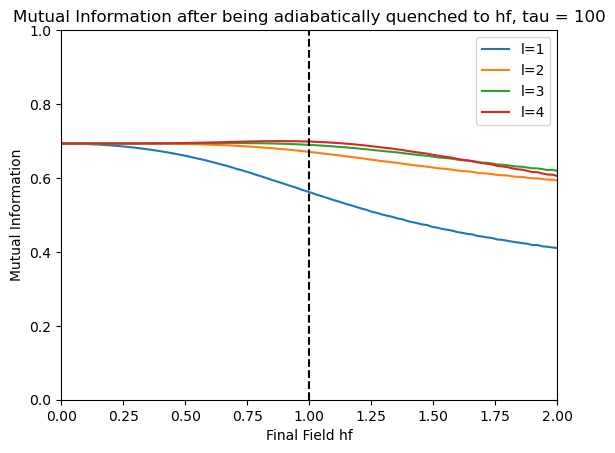

In [685]:
plt.plot(hf_list,np.log(Dat[1,:]/Dat[0,:]**2),label = "l=1")
plt.plot(hf_list,np.log(Dat[3,:]/Dat[1,:]**2),label = "l=2")
plt.plot(hf_list,np.log(Dat[5,:]/Dat[2,:]**2),label = "l=3")
plt.plot(hf_list,np.log(Dat[7,:]/Dat[3,:]**2),label = "l=4")
plt.xlim(hf_list[0],hf_list[-1])
plt.vlines(1,0,1, colors='k', linestyles='dashed')
plt.ylim(.0,1)
plt.legend()
plt.title("Mutual Information after being adiabatically quenched to hf, tau = 100")
plt.xlabel("Final Field hf")
plt.ylabel("Mutual Information")